# AGR (Analyze-Generate-Refine) Method Evaluation

This notebook evaluates the AGR query expansion method (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets, comparing against baseline.

## How to Run

1. Press "Run All" to execute all cells
2. All required DUMMY files will be created automatically if missing
3. Results will be saved to `output/eval/metric/agr/`
4. Plots will be saved to `output/eval/plot/agr/`


In [ ]:
# Setup: imports and path configuration
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Notebook is located at runner/eval/agr.ipynb
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root / "src"))

from eval import (
    compute_metrics_from_files,
    save_metrics_to_csv,
    load_run_file,
    load_qrels_file,
    compute_per_query_metric,
    compare_runs,
)
from eval.utils import (
    ensure_directory,
    find_top_delta_queries,
    create_summary_table,
)
from notebook.run_api import ensure_baseline_runs, run_method

print("Setup complete! Project root:", project_root)


Setup complete!


## Ensure DUMMY Files Exist


In [ ]:
datasets = ["trec_covid", "climate_fever"]
retrieval_methods = ["bm25"]  # only BM25 baseline is supported
method_name = "agr"
output_base = project_root / "output"

# Ensure baseline runs exist (BM25)
ensure_baseline_runs(datasets=datasets, retrieval_methods=["bm25"], top_k=100)

ensure_directory(output_base / "retrieval" / method_name)
ensure_directory(output_base / "eval" / "metric" / method_name)

for dataset in datasets:
    for retrieval in retrieval_methods:
        run_path = output_base / "retrieval" / method_name / f"{retrieval}_{dataset}_DUMMY.csv"
        if not run_path.exists():
            from eval.utils import create_dummy_run_file
            create_dummy_run_file(str(run_path), num_queries=10, num_docs_per_query=100)
            print(f"Created dummy run: {run_path}")

print("AGR DUMMY method runs check complete!")


Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\agr\bm25_trec_covid_DUMMY.csv
Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\agr\tf_idf_trec_covid_DUMMY.csv
Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\agr\bm25_climate_fever_DUMMY.csv
Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\agr\tf_idf_climate_fever_DUMMY.csv
DUMMY files check complete!


## Compute Metrics for All 4 Combos


In [9]:
all_metrics = {}

for dataset in datasets:
    qrels_path = output_base / 'ingest' / dataset / 'qrels.csv'
    
    for retrieval in retrieval_methods:
        run_path = output_base / 'retrieval' / method_name / f'{retrieval}_{dataset}_DUMMY.csv'
        metric_path = output_base / 'eval' / 'metric' / method_name / f'{retrieval}_{dataset}_DUMMY.csv'
        
        metrics = compute_metrics_from_files(str(run_path), str(qrels_path), k=10)
        save_metrics_to_csv(metrics, str(metric_path), dataset=dataset, method=method_name, retrieval=retrieval)
        
        all_metrics[(dataset, method_name, retrieval)] = metrics
        print(f"{retrieval} × {dataset}: nDCG@10={metrics['ndcg@10']:.4f}, MAP={metrics['map']:.4f}")

print("\nMetrics computation complete!")


bm25 × trec_covid: nDCG@10=1.0000, MAP=1.0000
tf_idf × trec_covid: nDCG@10=1.0000, MAP=1.0000
bm25 × climate_fever: nDCG@10=1.0000, MAP=1.0000
tf_idf × climate_fever: nDCG@10=1.0000, MAP=1.0000

Metrics computation complete!


## Compare with Baseline


In [ ]:
comparison_results = []

for dataset in datasets:
    qrels_path = output_base / 'ingest' / dataset / 'qrels.csv'
    
    for retrieval in retrieval_methods:
        run_path = output_base / "retrieval" / method_name / f"{retrieval}_{dataset}_DUMMY.csv"
        baseline_run_path = output_base / "retrieval" / "baseline" / f"{retrieval}_{dataset}.csv"
        
        stats = compare_runs(str(baseline_run_path), str(run_path), str(qrels_path), metric='ndcg@10', k=10)
        
        comparison_results.append({
            'dataset': dataset,
            'retrieval': retrieval,
            'baseline_mean': stats['baseline_mean'],
            'agr_mean': stats['system_mean'],
            'difference': stats['mean_difference'],
            'p_value': stats['p_value']
        })
        
        print(f"{retrieval} × {dataset}: Δ={stats['mean_difference']:.4f}, p={stats['p_value']:.4f}")

comparison_df = pd.DataFrame(comparison_results)
print("\nComparison Summary:")
print(comparison_df.to_string(index=False))

# Save p-values and CIs to JSON
import json
pvals_path = output_base / "eval" / "metric" / method_name / "pvals_DUMMY.json"
ensure_directory(pvals_path.parent)
pvals_data = {
    'method': method_name,
    'comparisons': comparison_results
}
with open(pvals_path, 'w') as f:
    json.dump(pvals_data, f, indent=2)
print(f"\nP-values and CIs saved to: {pvals_path}")


bm25 × trec_covid: Δ=0.0000, p=nan
tf_idf × trec_covid: Δ=0.0000, p=nan
bm25 × climate_fever: Δ=0.0000, p=nan
tf_idf × climate_fever: Δ=0.0000, p=nan

Comparison Summary:
      dataset retrieval  baseline_mean  agr_mean  difference  p_value
   trec_covid      bm25            1.0       1.0         0.0      NaN
   trec_covid    tf_idf            1.0       1.0         0.0      NaN
climate_fever      bm25            1.0       1.0         0.0      NaN
climate_fever    tf_idf            1.0       1.0         0.0      NaN


## Summary and Top Delta Queries


In [ ]:
summary_df = create_summary_table(all_metrics)
summary_path = output_base / 'eval' / 'metric' / method_name / f'summary_DUMMY.csv'
summary_df.to_csv(summary_path, index=False)
print("Summary Metrics Table:")
print(summary_df.to_string(index=False))

# Top delta queries
dataset_example = datasets[0]
retrieval_example = retrieval_methods[0]

qrels = load_qrels_file(str(output_base / 'ingest' / dataset_example / 'qrels.csv'))
baseline_run = load_run_file(str(output_base / "retrieval" / "baseline" / f"{retrieval_example}_{dataset_example}.csv"))
agr_run = load_run_file(str(output_base / "retrieval" / method_name / f"{retrieval_example}_{dataset_example}_DUMMY.csv"))

baseline_scores = compute_per_query_metric(baseline_run, qrels, metric='ndcg@10', k=10)
agr_scores = compute_per_query_metric(agr_run, qrels, metric='ndcg@10', k=10)

top_positive, top_negative = find_top_delta_queries(baseline_scores, agr_scores, top_n=10)

print(f"\nTop 5 Positive Δ (nDCG@10):")
for qid, delta in top_positive[:5]:
    print(f"  {qid}: +{delta:.4f}")

print(f"\nTop 5 Negative Δ (nDCG@10):")
for qid, delta in top_negative[:5]:
    print(f"  {qid}: {delta:.4f}")


Summary Metrics Table:
      dataset method retrieval  ndcg@10  map  recall@100  mrr
   trec_covid    agr      bm25      1.0  1.0         1.0  1.0
   trec_covid    agr    tf_idf      1.0  1.0         1.0  1.0
climate_fever    agr      bm25      1.0  1.0         1.0  1.0
climate_fever    agr    tf_idf      1.0  1.0         1.0  1.0

Top 5 Positive Δ (nDCG@10):
  q006: +0.0000
  q009: +0.0000
  q003: +0.0000
  q008: +0.0000
  q002: +0.0000

Top 5 Negative Δ (nDCG@10):
  q006: 0.0000
  q009: 0.0000
  q003: 0.0000
  q008: 0.0000
  q002: 0.0000


## Plot nDCG@10 Comparison


Plot saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\plot\agr_ndcg_DUMMY.png


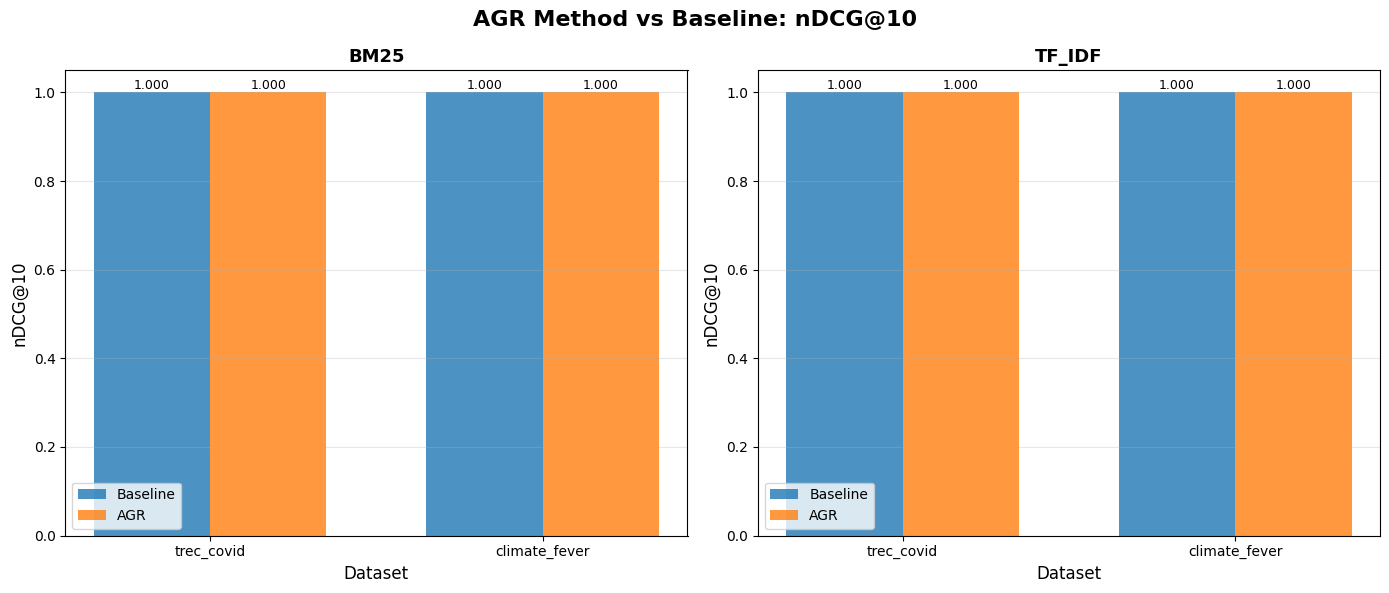

In [ ]:
from eval.compute_metrics import compute_metrics_from_files as load_metrics

baseline_metrics = {}
for dataset in datasets:
    for retrieval in retrieval_methods:
        qrels_path = output_base / "ingest" / dataset / "qrels.csv"
        baseline_run_path = output_base / "retrieval" / "baseline" / f"{retrieval}_{dataset}.csv"
        baseline_metrics[(dataset, retrieval)] = load_metrics(str(baseline_run_path), str(qrels_path), k=10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('AGR Method vs Baseline: nDCG@10', fontsize=16, fontweight='bold')

for idx, retrieval in enumerate(retrieval_methods):
    ax = axes[idx]
    x = np.arange(len(datasets))
    width = 0.35
    
    baseline_scores = [baseline_metrics[(d, retrieval)]['ndcg@10'] for d in datasets]
    agr_scores = [all_metrics[(d, method_name, retrieval)]['ndcg@10'] for d in datasets]
    
    bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8)
    bars2 = ax.bar(x + width/2, agr_scores, width, label='AGR', alpha=0.8)
    
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('nDCG@10', fontsize=12)
    ax.set_title(f'{retrieval.upper()}', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plot_path = output_base / 'eval' / 'plot' / f'{method_name}_ndcg_DUMMY.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")
plt.show()